In [113]:
import scipy

from skimage.io import imread
from skimage.feature import graycomatrix, graycoprops
from skimage import filters
from skimage import measure

import rasterio, os, glob, warnings, time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.rcParams['font.size'] = 18
import seaborn as sns

import rioxarray as rx

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.inspection import permutation_importance 

from sampling import *
from utils import *

warnings.filterwarnings("ignore")
plt.rcParams["figure.autolayout"] = True

In [2]:
# Input image paths
basepath = 'D:\Berkeley\Research\ExplainableWildfire\datasets'
os.chdir(basepath)

img_train = sorted(glob.glob('s2*.tif'))
dem_train = sorted(glob.glob('dem*.tif'))
slope_train = sorted(glob.glob('slope*.tif'))
aoi_train = sorted(glob.glob('fire*.tif'))
lulc_train = sorted(glob.glob('lulc*.tif'))

# Weather data
rmin_train = sorted(glob.glob('rmin*.tif'))
rmax_train = sorted(glob.glob('rmax*.tif'))
tmmn_train = sorted(glob.glob('tmmn*.tif'))
tmmx_train = sorted(glob.glob('tmmx*.tif'))
vs_train = sorted(glob.glob('vs*.tif'))


In [3]:
img_train, dem_train, slope_train, lulc_train, aoi_train = paths(basepath)

In [4]:
paths_df = pd.DataFrame(data={'s2':img_train, 'slope': slope_train, "lulc":lulc_train, 'aoi':aoi_train, 'dem': dem_train})
print('Number of fires:', paths_df.shape[0])
paths_df.head()

Number of fires: 37


,s2,slope,lulc,aoi,dem
0,s2_aoi_ll00.tif,slope_aoi00_reproj.tif,lulc_aoi00_reproj.tif,fire00_reproj.tif,dem_aoi00_reproj.tif
1,s2_aoi_ll01.tif,slope_aoi01_reproj.tif,lulc_aoi01_reproj.tif,fire01_reproj.tif,dem_aoi01_reproj.tif
2,s2_aoi_ll04.tif,slope_aoi04_reproj.tif,lulc_aoi04_reproj.tif,fire04_reproj.tif,dem_aoi04_reproj.tif
3,s2_aoi_ll05.tif,slope_aoi05_reproj.tif,lulc_aoi05_reproj.tif,fire05_reproj.tif,dem_aoi05_reproj.tif
4,s2_aoi_ll08.tif,slope_aoi08_reproj.tif,lulc_aoi08_reproj.tif,fire08_reproj.tif,dem_aoi08_reproj.tif


In [8]:
idx = np.random.randint(paths_df.shape[0])
idx = 14
idx

14

In [9]:
_ = paths_df.iloc[idx]

_s2_b = rx.open_rasterio(_['s2'])[0].to_numpy()
_s2_g = rx.open_rasterio(_['s2'])[1].to_numpy()
_s2_r = rx.open_rasterio(_['s2'])[2].to_numpy()
_s2_n = rx.open_rasterio(_['s2'])[3].to_numpy()
_slope = rx.open_rasterio(_['slope']).to_numpy()[0]
_dem = rx.open_rasterio(_['dem']).to_numpy()[0]

x, y = np.gradient(_dem)
_aspect = np.arctan2(-x, y)

_lulc = rx.open_rasterio(_['lulc']).to_numpy()[0]
_aoi = rx.open_rasterio(_['aoi']).to_numpy()[0]

_ndvi = (_s2_n/65535-_s2_r/65535)/(_s2_n/65535+_s2_r/65535)

_savi = (_s2_n/65535-_s2_r/65535)/(_s2_n/65535+_s2_r/65535+0.5)*(1+0.5)

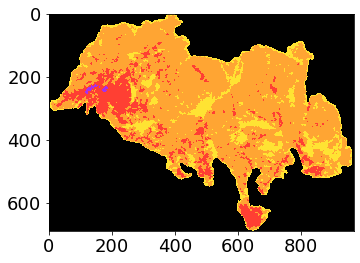

In [15]:
plt.imshow(_aoi)
cmap = matplotlib.colors.ListedColormap(['#000000','#FFE333','#FFA533','#FF3F33','#A730EC'])
_aoi[_aoi > 4] = 0; _aoi[_aoi < 1] = 0
im=plt.imshow(_aoi, cmap=cmap, vmin=0, vmax=4)

In [10]:
low = np.where(_aoi==1, 1, 0)
low_med = np.where(_aoi==2, 1, 0)
med_high = np.where(_aoi==3, 1, 0)
high = np.where(_aoi==4, 1, 0)

In [12]:
from skimage.feature import blob_dog, blob_log, blob_doh

In [47]:
blobs_log = blob_log(_ndvi)

In [48]:
blobs_log.shape

(25, 3)

In [115]:
sample_size=int(10000)

In [116]:
x,y = np.where(_aoi==1)
indexes = np.array([x,y]).T
np.random.seed(1844)
low_locations = indexes[np.random.choice(np.arange(indexes.shape[0]), size=sample_size)]
patch_size = 100

low_patches = []
for loc in low_locations:
    low_patches.append(_s2_r[loc[0]:loc[0] + patch_size,
                               loc[1]:loc[1] + patch_size])

low_xs = []
low_ys = []
for patch in low_patches:
    glcm = graycomatrix(patch.astype(np.uint8), distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    low_xs.append(graycoprops(glcm, 'dissimilarity')[0, 0])
    low_ys.append(graycoprops(glcm, 'correlation')[0, 0])                            

In [120]:
x,y = np.where(_aoi==2)
indexes = np.array([x,y]).T
np.random.seed(1844)
med_low_locations = indexes[np.random.choice(np.arange(indexes.shape[0]), size=sample_size)]
patch_size = 100

med_low_patches = []
for loc in med_low_locations:
    low_patches.append(_s2_r[loc[0]:loc[0] + patch_size,
                               loc[1]:loc[1] + patch_size])

med_low_xs = []
med_low_ys = []
for patch in med_low_patches:
    glcm = graycomatrix(patch.astype(np.uint8), distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    med_low_xs.append(graycoprops(glcm, 'dissimilarity')[0, 0])
    med_low_ys.append(graycoprops(glcm, 'correlation')[0, 0])     

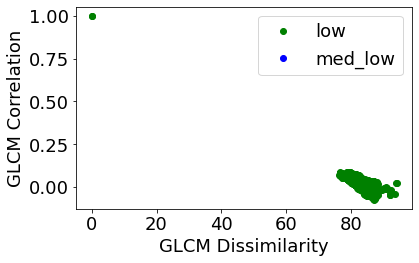

In [122]:
fig, ax = plt.subplots(1)

ax.plot(low_xs[:len(low_patches)], low_ys[:len(low_patches)], 'go',
        label='low')

ax.plot(med_low_xs[:len(low_patches)], med_low_ys[:len(low_patches)], 'bo',
        label='med_low', )

ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()
plt.show()

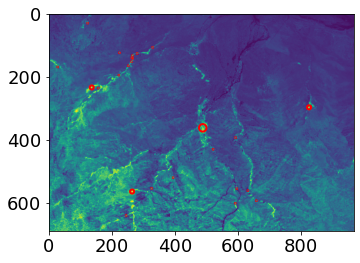

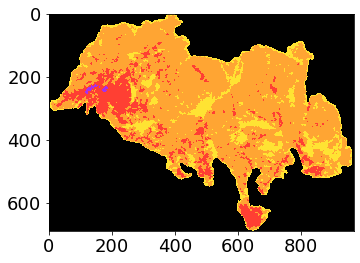

In [50]:
fig, ax = plt.subplots(1)

ax.imshow(_ndvi)

for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x,y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)

plt.show()

cmap = matplotlib.colors.ListedColormap(['#000000','#FFE333','#FFA533','#FF3F33','#A730EC'])
_aoi[_aoi > 4] = 0; _aoi[_aoi < 1] = 0
im=plt.imshow(_aoi, cmap=cmap, vmin=0, vmax=4)